In [42]:
!pip install prophet

In [43]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [44]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [46]:
goog = df[df['Name'] == 'GOOG'][['Close']].copy()

In [47]:
goog.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


In [48]:
goog.columns = ['y']
goog['ds'] = goog.index

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


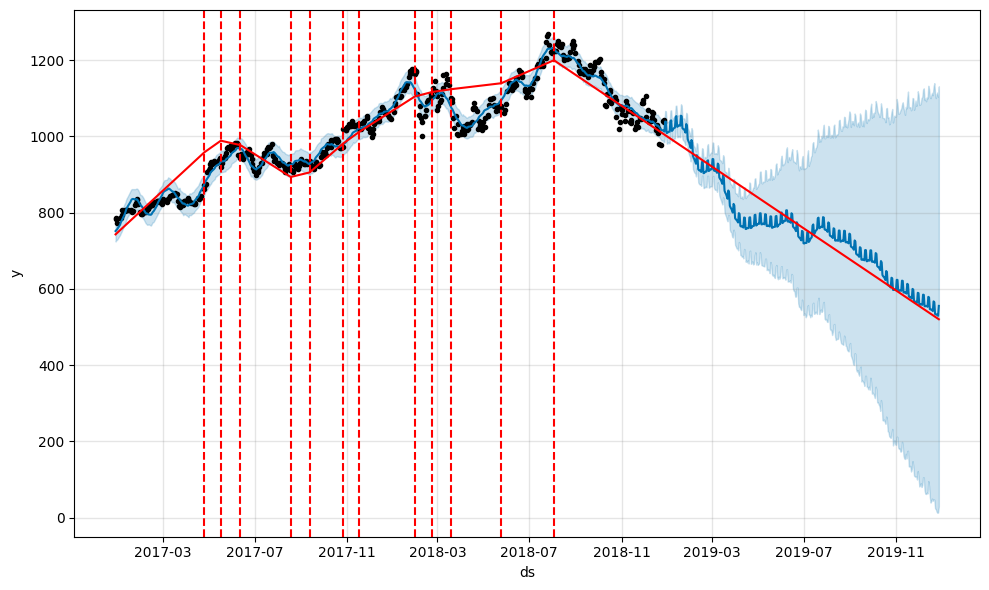

In [49]:
m = Prophet()
m.fit(goog.iloc[-252*2:])
future = m.make_future_dataframe(periods=365) # 365 calendar days corresponding to 252 trading days
forecast = m.predict(future)
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# not a great fit. some high frequency seasonal component in forecast due to false weekly seasonal component.
# Prophet only capable of producing linear and logistic trends. This forecast assumes stock price will continue to go down in future
# which may not be sensible

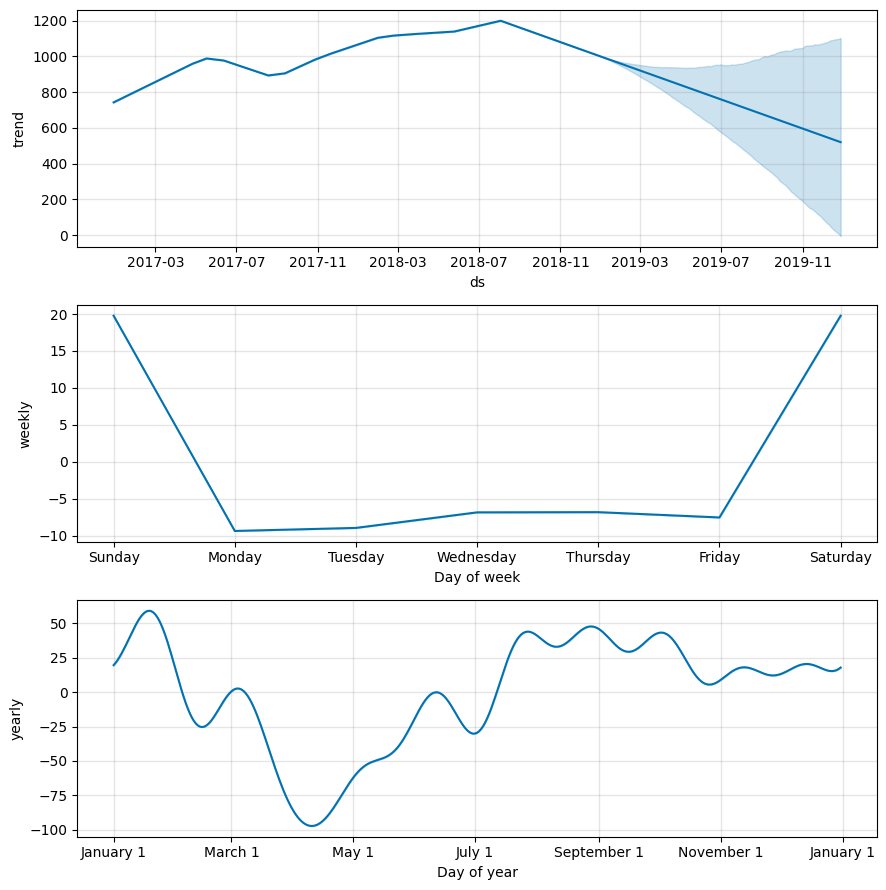

In [50]:
# prediction interval for trend gets big very rapidly showing the model is not sure of this trend
# there is a weekly seasonal component which makes no sense - values increase on weekend which can't be case because
# market closed on weekend. Yearly seasonal component magnitude is much smaller compared to trend, hence increase from
# April to August 'll be overtaken by trend.
m.plot_components(forecast);

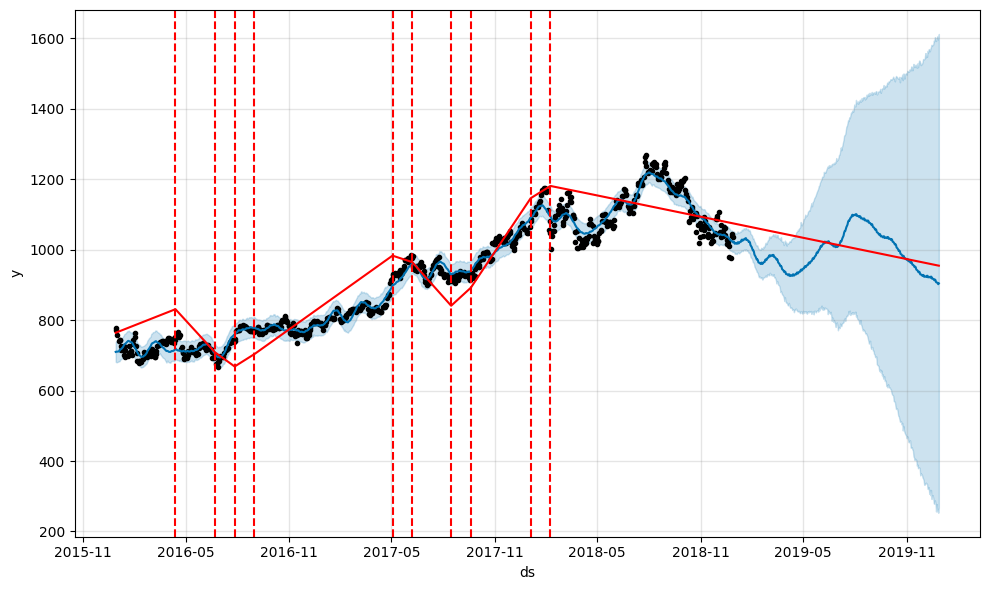

In [51]:
# BAD!!! From blog articles
m = Prophet(daily_seasonality=True) # daily_seasonality=True makes no sense because our data is daily
m.fit(goog.iloc[-252*3:])
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# plot not satisfactory because it's based on false presumptions

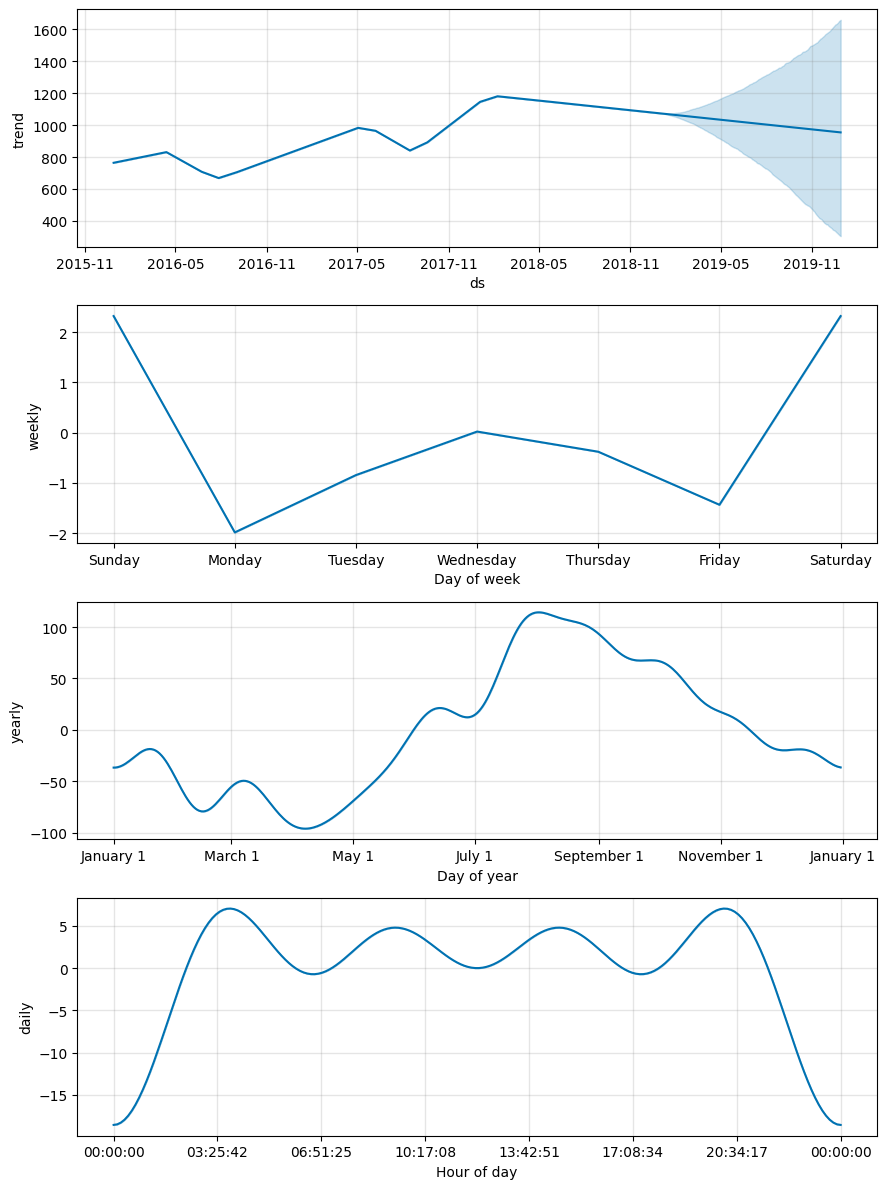

In [52]:
m.plot_components(forecast);
# our data is daily and therefore has no chance of knowing daily seasonality (periodic changes within the day)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


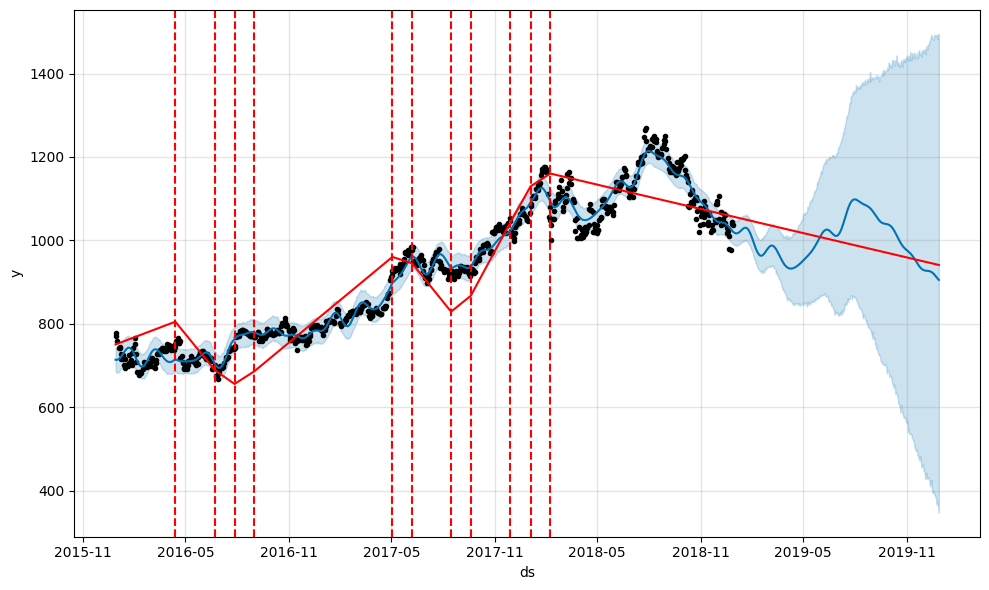

In [53]:
m = Prophet(weekly_seasonality=False) # weekly_seasonality=False will help us avoid any false weekly patterns
m.fit(goog.iloc[-252*3:])
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# now plot doesn't have those very small weekly jumps

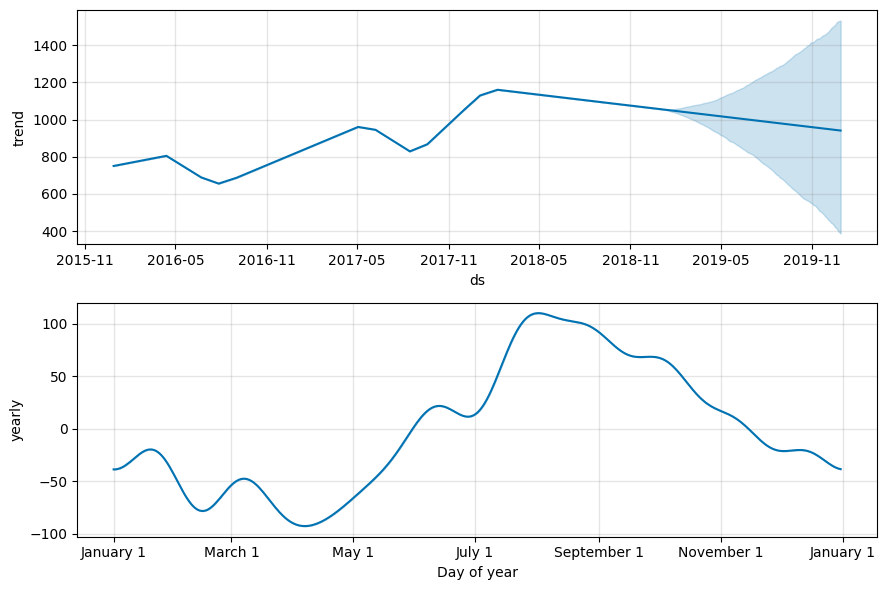

In [54]:
m.plot_components(forecast);
# no false weekly and daily patterns

In [55]:
# Cross-Validation: Goal in this notebook is to compare to baseline naive forecast (simply predicting the last value)

In [56]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [57]:
m = Prophet(weekly_seasonality=False)

In [58]:
m.fit(goog[-252*2:])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# try period=15, horizon=30
# try period=30, horizon=60
df_cv = cross_validation(
    m,
    initial='365 days',
    period='5 days',
    horizon='5 days')

INFO:prophet:Making 73 forecasts with cutoffs between 2017-12-28 00:00:00 and 2018-12-23 00:00:00


  0%|          | 0/73 [00:00<?, ?it/s]

In [60]:
df_cv.head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-12-29,1065.658110,1052.272471,1078.545791,1046.400024,2017-12-28
1,2018-01-02,1069.639082,1055.614257,1082.949242,1065.000000,2017-12-28
2,2018-01-03,1065.833196,1051.289945,1080.318521,1082.479980,2018-01-02
3,2018-01-04,1066.915458,1053.083339,1081.180049,1086.400024,2018-01-02
4,2018-01-05,1068.098182,1053.390697,1082.339950,1102.229980,2018-01-02
5,2018-01-08,1086.246858,1072.073671,1101.185334,1106.939941,2018-01-07
6,2018-01-09,1088.059884,1073.111715,1101.133392,1106.260010,2018-01-07
7,2018-01-10,1089.843150,1076.496829,1103.395310,1102.609985,2018-01-07
8,2018-01-11,1091.577146,1076.887658,1104.995461,1105.520020,2018-01-07
9,2018-01-12,1093.241802,1079.410367,1106.528227,1122.260010,2018-01-07


In [61]:
df_cv.shape

(251, 6)

In [62]:
naive = df_cv[['ds', 'yhat', 'y', 'cutoff']].copy()

In [63]:
# we will replace yhat with naive forecast
# cutoff column is where the forecast starts and ds column is the timestamp we are making forecast for
# Thus every forecast should come from its cutoff day. But not every cutoff day exists in time series because
# we have prices only for trading days. So we are going to look backwards to get the last known price and use that as prediction
naive_storage = np.zeros(naive.shape[0])
one_day = pd.Timedelta(1, 'day')
for i, row in naive.iterrows():
  cutoff = row['cutoff']
  # print(cutoff)

  # must find last cutoff that actually exists in df
  while cutoff not in goog.index: # this loop will quit only when we have a date that has a price
    cutoff = cutoff - one_day # we decrement cutoff by one day

  naive_storage[i] = goog.loc[cutoff]['y']

naive['yhat'] = naive_storage # we now have out naive forecast

In [64]:
pm = performance_metrics(df_cv)
pm['smape'].mean()

np.float64(0.03134179262866856)

In [65]:
naive_metrics = performance_metrics(naive)
naive_metrics['smape'].mean()
# naive forecast wins

np.float64(0.020548255026446992)

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


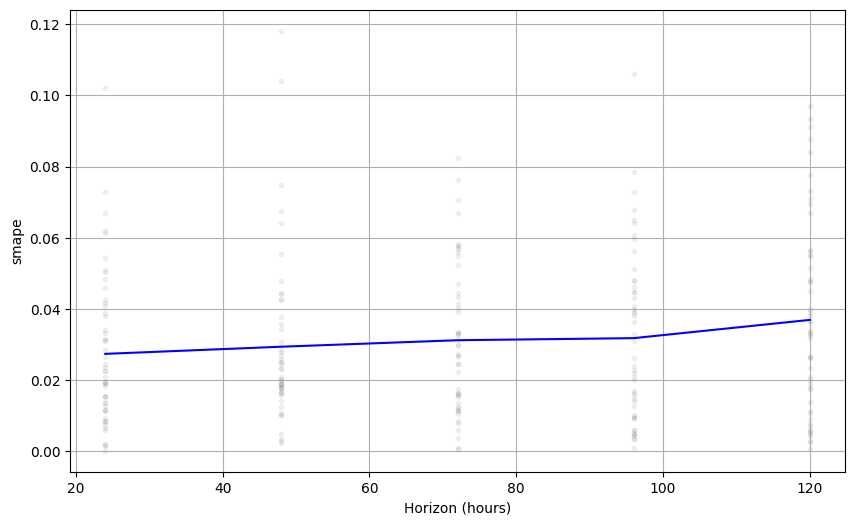

In [66]:
# make a plot of cross validation results
# as expected forecast error tends to grow over time
plot_cross_validation_metric(df_cv, metric='smape');

In [67]:
# Cross-Validation with Logged Data

In [68]:
log_goog = goog.copy()
log_goog['y'] = np.log(goog['y']) # remember log is box cox transform with lambda = 0

In [69]:
m = Prophet(weekly_seasonality=False)
m.fit(log_goog[-252*2:])
df_cv = cross_validation(
    m,
    initial='365 days',
    period='30 days',
    horizon='60 days')
pm = performance_metrics(df_cv)
pm['smape'].mean()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 11 forecasts with cutoffs between 2018-01-02 00:00:00 and 2018-10-29 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

np.float64(0.014651294765539441)

In [70]:
naive = df_cv[['ds', 'yhat', 'y', 'cutoff']].copy()
naive_storage = np.zeros(naive.shape[0])
for i, row in naive.iterrows():
  cutoff = row['cutoff']
  # print(cutoff)

  # must find last cutoff that actually exists in df
  while cutoff not in goog.index:
    cutoff = cutoff - pd.Timedelta(1, 'day')

  naive_storage[i] = log_goog.loc[cutoff]['y']

naive['yhat'] = naive_storage
naive_metrics = performance_metrics(naive)
naive_metrics['smape'].mean()

# naive forecast wins

np.float64(0.008361150811971313)

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


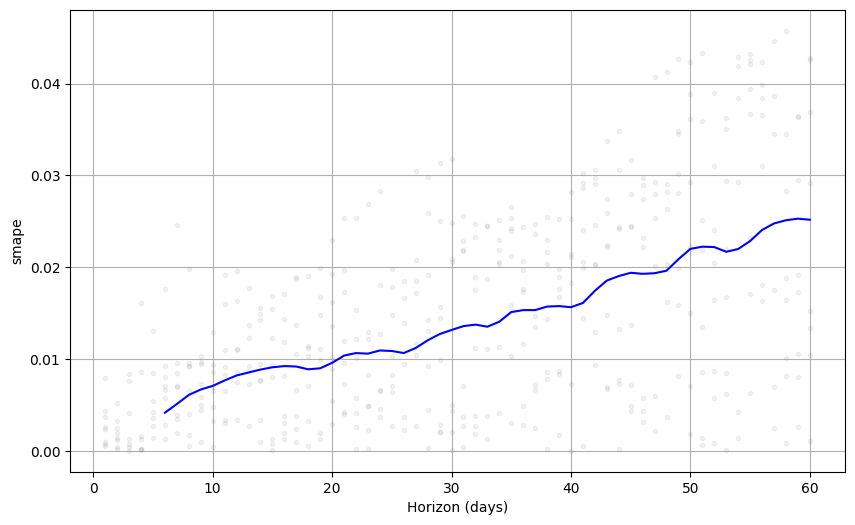

In [71]:
# plot of cross validation results
# over time forecast error increases
plot_cross_validation_metric(df_cv, metric='smape');